<a href="https://colab.research.google.com/github/edgleuma-abreu/IGTI/blob/main/Projeto_Aplicado_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTAÇÃO DE BIBLIOTECAS**

In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats

import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

import datetime

In [3]:
# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs




# settings
import warnings
warnings.filterwarnings("ignore")

In [13]:
#Ler dados
df =pd.read_csv("dataset_pa_v2.csv", delimiter=";")



In [14]:
df.head(20)

,datahora,mem,cpu_usage
0,02/10/22 14:00,223,6.37
1,02/10/22 15:00,224,6.07
2,02/10/22 16:00,224,6.31
3,02/10/22 17:00,224,6.18
4,02/10/22 18:00,224,6.28
5,02/10/22 19:00,224,6.16
6,02/10/22 20:00,224,6.30
7,02/10/22 21:00,223,6.21
8,02/10/22 22:00,224,6.14
9,02/10/22 23:00,224,5.94


In [15]:
#Tamanho do dataset
df.shape

(337, 3)

In [16]:
#Verificar valores nulos
df.isna().sum()

datahora     0
mem          0
cpu_usage    0
dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   datahora   337 non-null    object 
 1   mem        337 non-null    int64  
 2   cpu_usage  337 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 8.0+ KB


In [19]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
mem,337.0,218.857567,11.18289,169.00,216.00,223.00,225.0,228.0
cpu_usage,337.0,7.328605,2.27618,5.08,6.16,6.85,7.4,21.1


In [8]:
#converter campo "datahora"para datetime
#df[["datahora"]] = df[["datahora"]].apply(pd.to_datetime, format="%d/%m/%y %H:%M")

#print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   datahora   169 non-null    datetime64[ns]
 1   mem        169 non-null    int64         
 2   cpu_usage  169 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 4.1 KB
None


In [20]:
df.index = df[["datahora"]].apply(pd.to_datetime, format="%d/%m/%y %H:%M")



In [21]:
#eliminar a coluna DATE, pois ela já seria o indice
df.drop("datahora", inplace=True, axis=1)



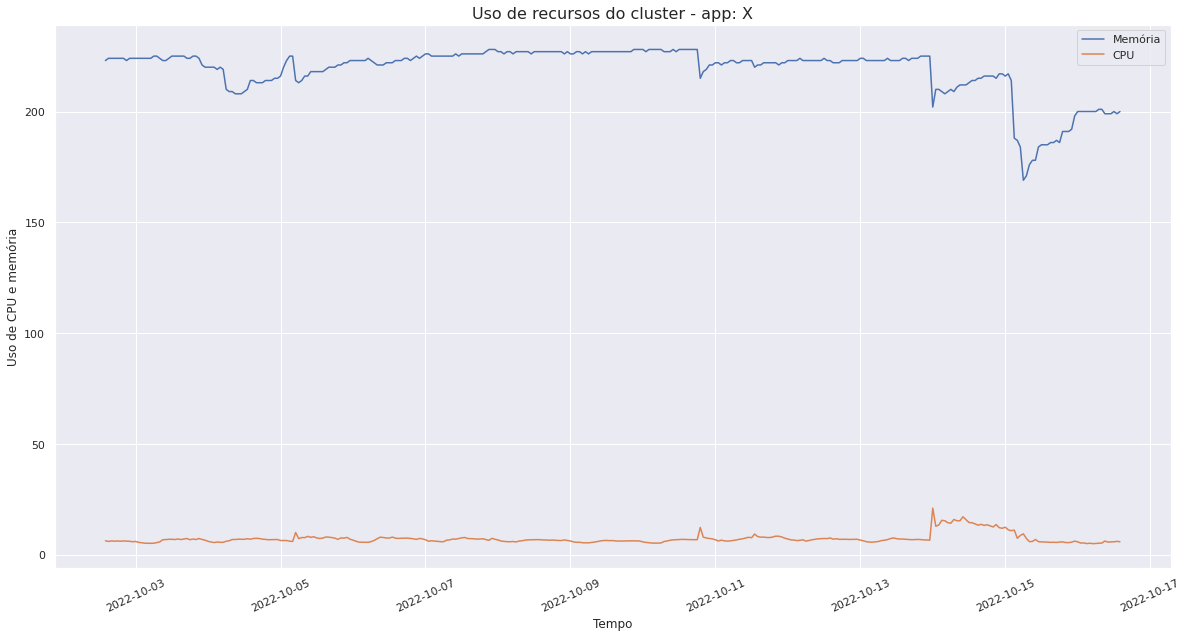

In [22]:
sns.set(rc={'figure.figsize':(20,10)})

#sns.lineplot(x='datahora', y='mem', data = df)
#sns.lineplot(x='datahora', y='cpu_usage', data = df)
plt.plot(df.index, df.mem, df.cpu_usage);
plt.title("Uso de recursos do cluster - app: X", fontsize=16)
plt.ylabel("Uso de CPU e memória")
plt.xlabel("Tempo")

plt.xticks(rotation=25)

plt.legend( loc='middle right', labels=['Memória', 'CPU'])



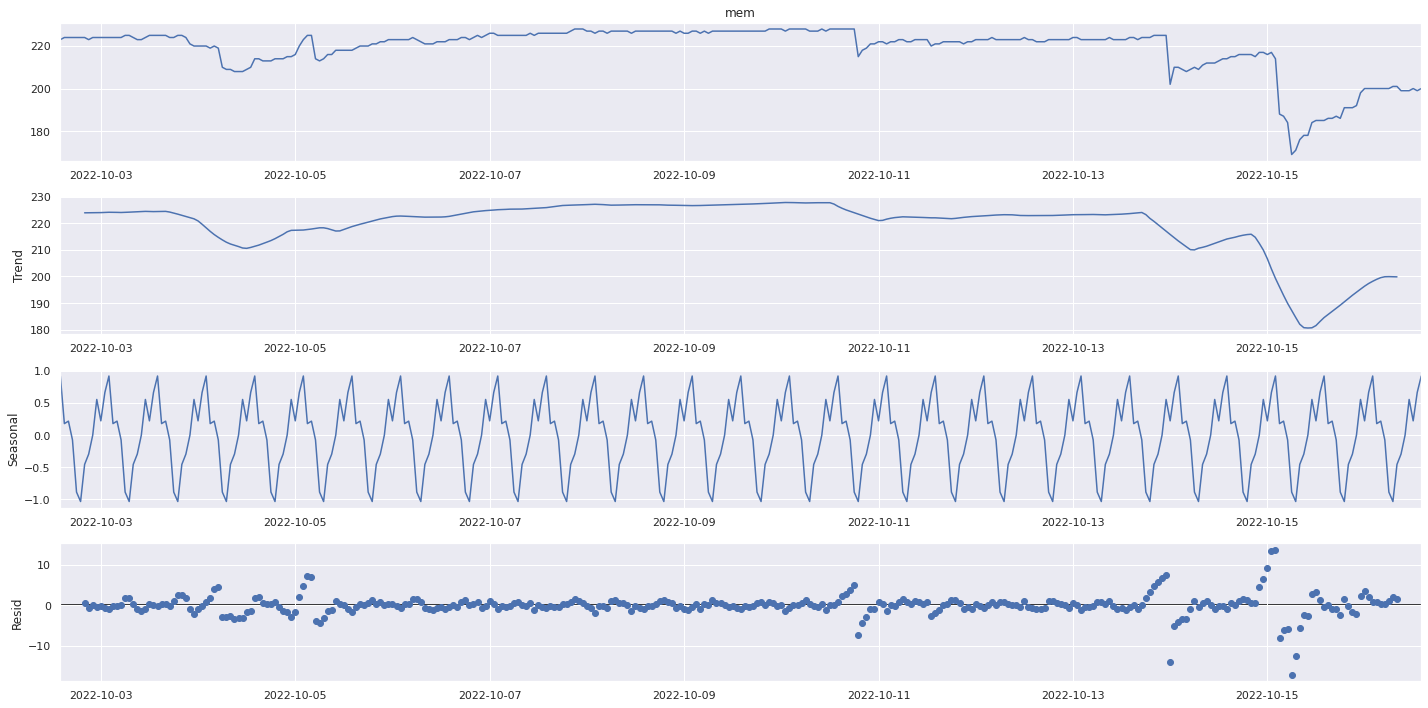

In [23]:
#TODO: Entender parâmetros - additive ou multiplicative / qtde de periods / Não entendi como interpreta o ruído/ Dá para fazer CPU e mem juntos ou tem que fazer separado mesmo?
result_mem = seasonal_decompose(df['mem'], model='additive', period=12)
fig = result_mem.plot()



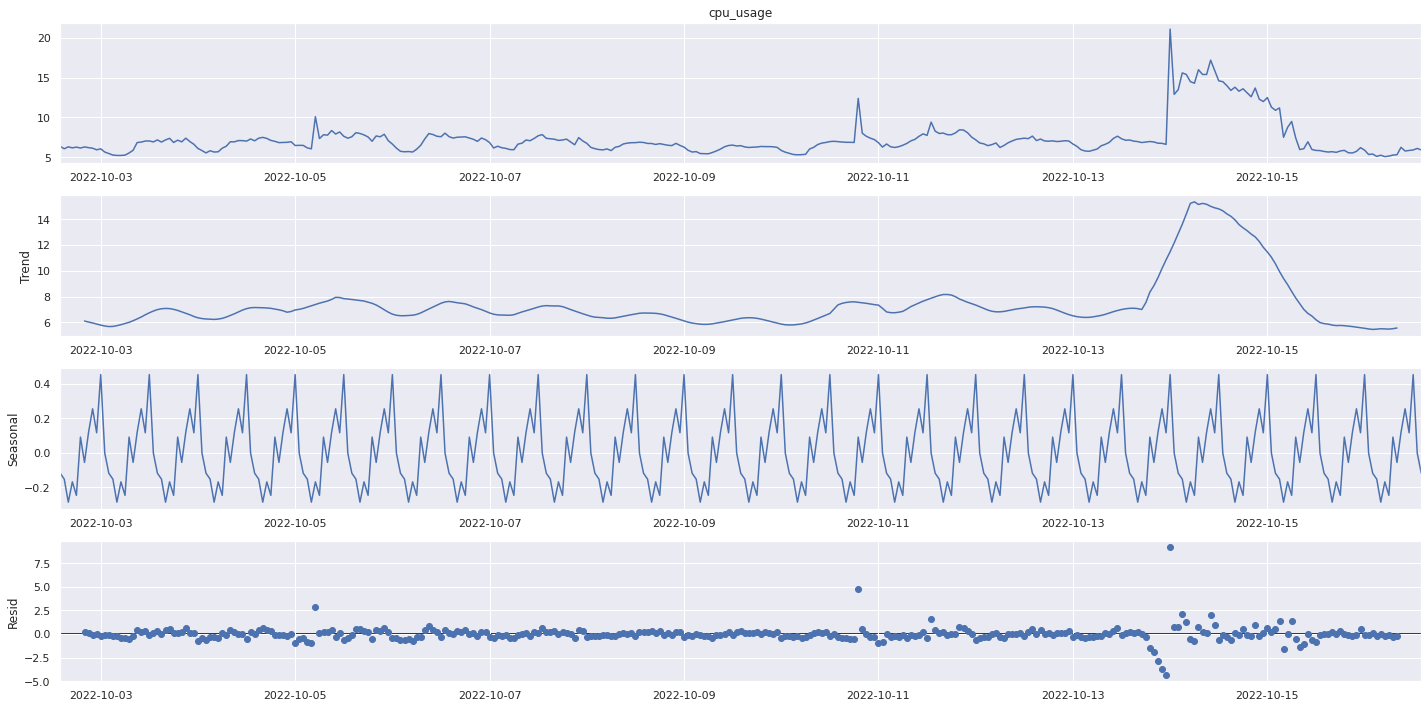

In [24]:
result_cpu = seasonal_decompose(df['cpu_usage'], model='additive', period=12)
fig = result_cpu.plot()


In [25]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [26]:
# aplicando adfuller_test em cada coluna
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n') 

    Augmented Dickey-Fuller Test on "mem" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8668
 No. Lags Chosen       = 5
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.3478. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "cpu_usage" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7565
 No. Lags Chosen       = 4
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0648. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




In [27]:
# 1st difference
df_differenced = df.diff().dropna() #TODO: entender se eu poderia ter feito assim mesmo a CPU já sendo estacionária

In [28]:
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n') 

    Augmented Dickey-Fuller Test on "mem" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.4789
 No. Lags Chosen       = 4
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "cpu_usage" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -19.1391
 No. Lags Chosen       = 1
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




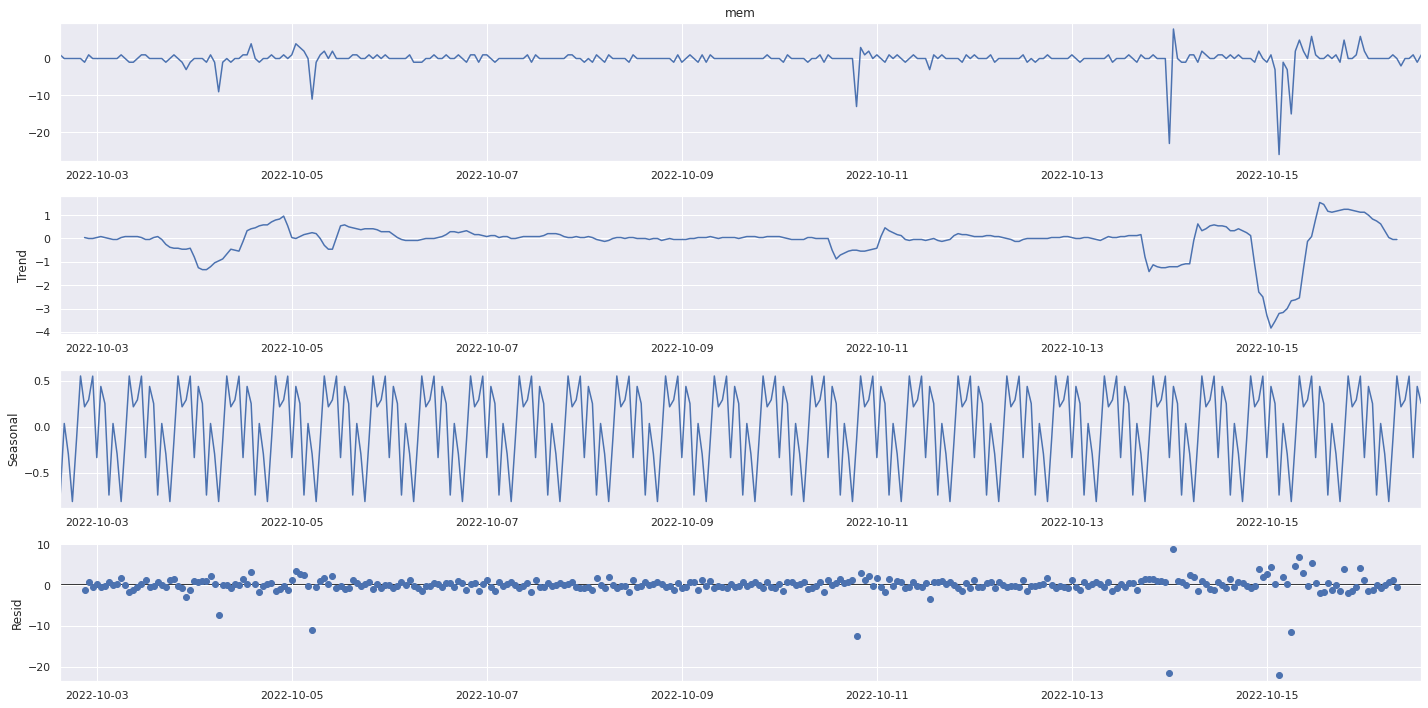

In [29]:
#Plotar série depois de transformar em estacionária
result_mem_new = seasonal_decompose(df_differenced['mem'], model='additive', period=12)
fig = result_mem_new.plot()

#TODO: entender como valida/interpreta isso

**DATASET MENSAL**

In [149]:
#Ler dados
df_mensal =pd.read_csv("dataset_mensal.csv", delimiter=";")

#mem: MiB
#cpu: mCores

In [118]:
df_mensal.head(20)

,datahora,mem_usage,cpu_usage
0,10/09/22 03:00,236,5.58
1,10/09/22 09:00,236,5.46
2,10/09/22 15:00,236,5.99
3,10/09/22 21:00,236,5.85
4,11/09/22 03:00,236,5.44
5,11/09/22 09:00,236,5.31
6,11/09/22 15:00,237,5.76
7,11/09/22 21:00,237,5.70
8,12/09/22 03:00,237,5.50
9,12/09/22 09:00,237,5.49


In [147]:
#Verificar dados nulos
df_mensal.isna().sum()

## Não foram identificados dados NULOS no dataset

datahora     0
mem_usage    0
cpu_usage    0
dtype: int64

In [150]:
#Validar tipos de dados
df_mensal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   datahora   121 non-null    object 
 1   mem_usage  121 non-null    int64  
 2   cpu_usage  121 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.0+ KB


In [151]:
#converter campo "datahora" para datetime
df_mensal[["datahora"]] = df_mensal[["datahora"]].apply(pd.to_datetime, format="%d/%m/%y %H:%M")

print(df_mensal.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   datahora   121 non-null    datetime64[ns]
 1   mem_usage  121 non-null    int64         
 2   cpu_usage  121 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 3.0 KB
None


In [152]:
#Verificar correlação entre os dados
df_mensal.corr()

###Não foi identificada correlação entre as variáveis


,mem_usage,cpu_usage
mem_usage,1.00000,-0.02545
cpu_usage,-0.02545,1.00000


(array([738407., 738411., 738415., 738419., 738423., 738427., 738429.,
        738433., 738437.]), <a list of 9 Text major ticklabel objects>)

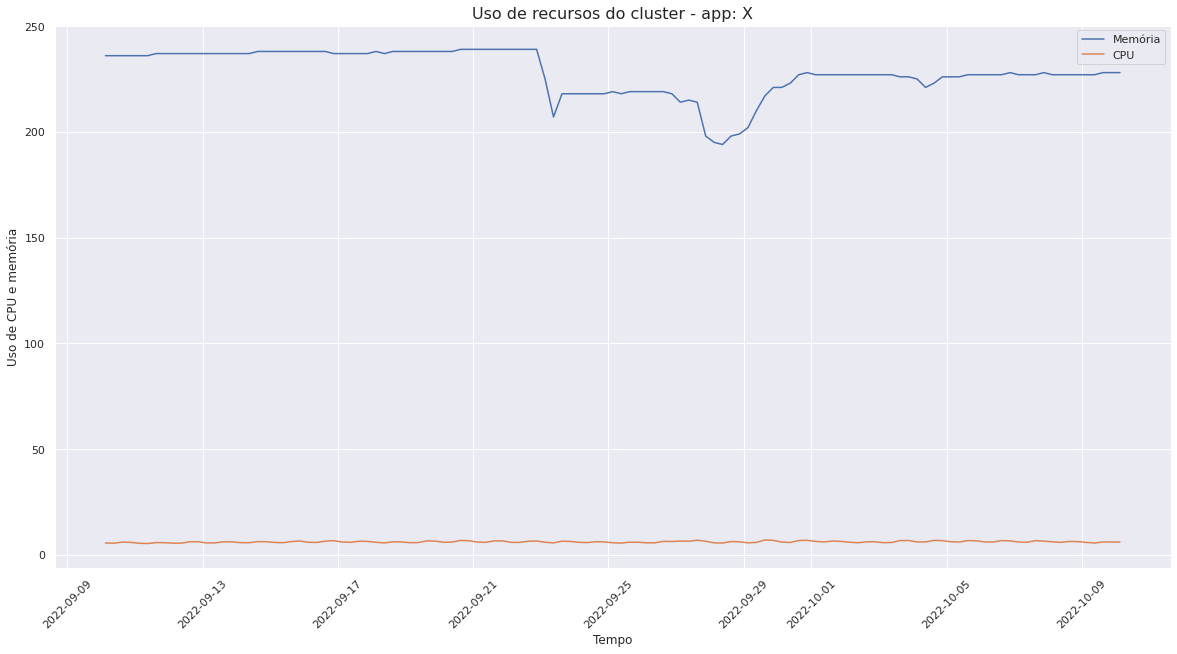

In [153]:
sns.set(rc={'figure.figsize':(20,10)})
sns.lineplot(x='datahora', y='mem_usage', data = df_mensal)
sns.lineplot(x='datahora', y='cpu_usage', data = df_mensal)
plt.title("Uso de recursos do cluster - app: X", fontsize=16)
plt.ylabel("Uso de CPU e memória")
plt.xlabel("Tempo")
plt.legend( labels=['Memória', 'CPU'])
plt.xticks(rotation=45)





In [12]:
result = seasonal_decompose(df_mensal['mem_usage'], model='additive', period=2)
fig = result.plot()
fig.set_size_inches((12, 8))
plt.show()

NameError: ignored

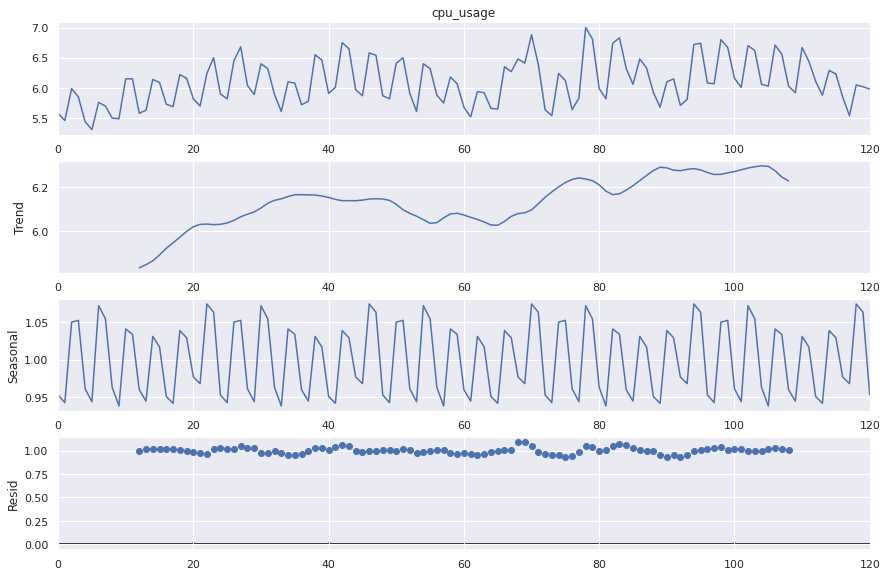

In [155]:
result = seasonal_decompose(df_mensal['cpu_usage'], model='additive', period=2)
fig = result.plot()
fig.set_size_inches((12, 8))
plt.show()

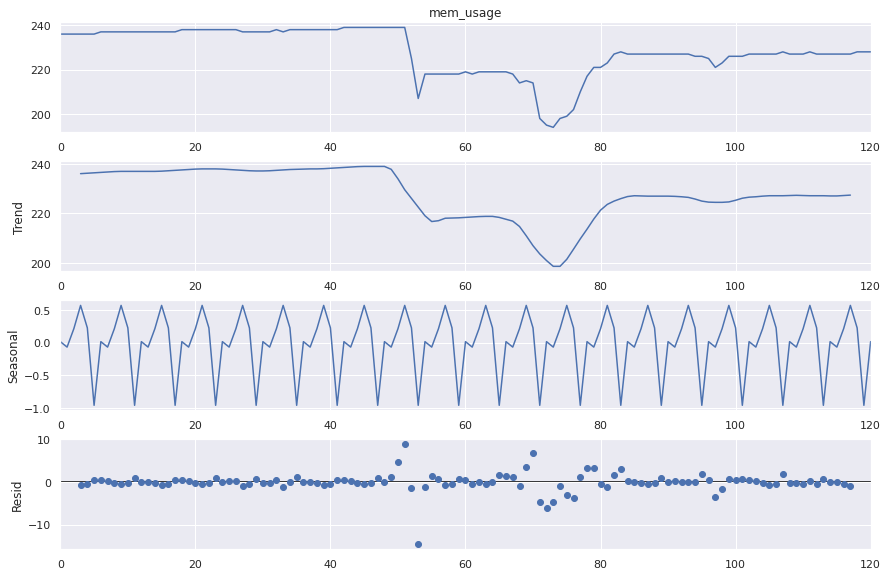

In [158]:

result = seasonal_decompose(df_mensal['mem_usage'], model='additive', period=6)
fig = result.plot()
fig.set_size_inches((12, 8))
plt.show()

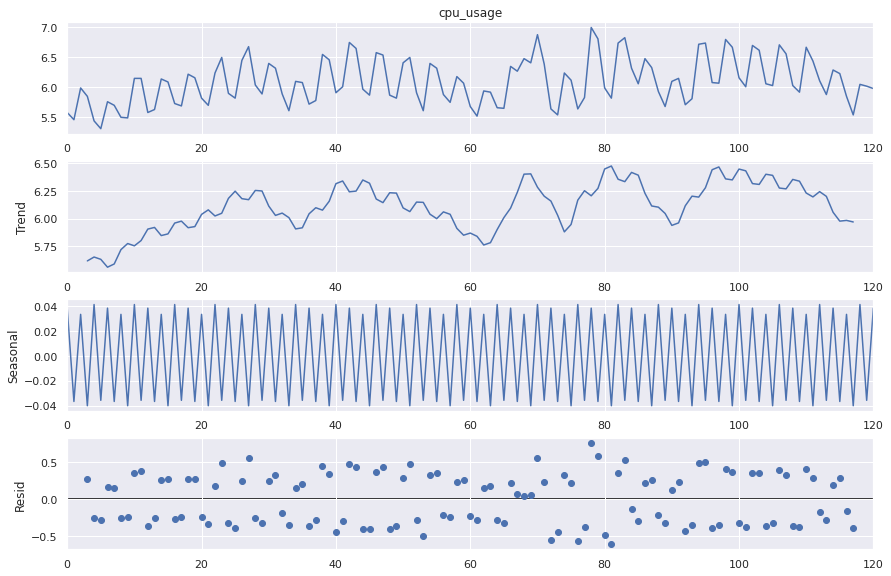

In [157]:
seasonal = seasonal_decompose(df_mensal['cpu_usage'], model='additive', period=6)
fig = seasonal.plot()
fig.set_size_inches((12, 8))
plt.show()

**PREPARAÇÃO DOS DADOS**

##Fazer resample do dataset_pa e ver se fica bom ou pior :(

##Entender o decompose

In [8]:
#Ler dados
df_teste =pd.read_csv("dataset_estudo.csv", delimiter=";")

In [11]:
df_teste.shape

df_teste.head()

,datetime,cpu,mem,networkio
0,2022-07-25T03:48:30-03:00,0.000840,52142080,22.937.234.682.757.800
1,2022-07-25T03:48:45-03:00,0.000772,52432896,16.626.793.578.206.900
2,2022-07-25T03:49:00-03:00,0.000854,52162560,1.761.552.926.755.880
3,2022-07-25T03:49:15-03:00,0.000854,52162560,19.774.713.787.037.200
4,2022-07-25T03:49:30-03:00,0.000854,52162560,19.774.713.787.037.200


In [14]:
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57598 entries, 0 to 57597
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   datetime   57598 non-null  object 
 1   cpu        57598 non-null  float64
 2   mem        57598 non-null  object 
 3   networkio  57598 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.8+ MB


In [26]:
df_teste.drop(['networkio'],axis=1)

,datetime,cpu,mem
0,2022-07-25 03:48:30-03:00,0.000840,52142080
1,2022-07-25 03:48:45-03:00,0.000772,52432896
2,2022-07-25 03:49:00-03:00,0.000854,52162560
3,2022-07-25 03:49:15-03:00,0.000854,52162560
4,2022-07-25 03:49:30-03:00,0.000854,52162560
...,...,...,...
57593,2022-07-25 15:42:00-03:00,0.000885,52207616
57594,2022-07-25 15:42:15-03:00,0.000898,52207616
57595,2022-07-25 15:42:30-03:00,0.000888,52207616
57596,2022-07-25 15:42:45-03:00,0.000882,52207616


In [30]:
df_teste["datetime"] = pd.to_datetime,(df_teste["datetime"])

#

ValueError: ignored

In [25]:
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57598 entries, 0 to 57597
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype                                 
---  ------     --------------  -----                                 
 0   datetime   57598 non-null  datetime64[ns, pytz.FixedOffset(-180)]
 1   cpu        57598 non-null  float64                               
 2   mem        57598 non-null  object                                
 3   networkio  57598 non-null  object                                
dtypes: datetime64[ns, pytz.FixedOffset(-180)](1), float64(1), object(2)
memory usage: 1.8+ MB


In [27]:
df_teste_ajustado = df_teste.resample('H').mean()


df['date'] = pd.to_datetime(df['date'])
weekly_summary = df.story_point.resample('W', on='date').sum()

TypeError: ignored